# Crowd Counting
by David Ohm

This notebook will step you through the process of training and testing a deep learning model for estimating crowd density. The output heatmap (i.e., density map) can be used to compute an estimate of the total number of peaople in an image. Note - the same model could be trained to count other objects (i.e., vehicles, fruit, microscopic organisms, etc.). 

The model in this notebook is based on the model in the paper [CSRNet: Dilated Convolutional Neural Networks for Understanding the Highly Congested Scenes](https://arxiv.org/abs/1802.10062).

### Results:

TBD   

### Dataset:

ShanghaiTech dataset

### Training Parameters:

1. *Loss* = MSE;

2. *Optimizer* = SGD(lr=1e-6);

3. *Batch size*: 4;

4. *Data augmentation*: Flip horizontally randomly;

5. *Weights*: Got best weights of SHB in epoch xxx, the best one of SHA in epoch xxx   

In [1]:
import tensorflow as tf

import h5py
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm as CM

# from PIL import Image
# os.environ["CUDA_VISIBLE_DEVICES"]="0"1

2023-12-16 19:29:00.469059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 19:29:00.469096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 19:29:00.469121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 19:29:00.478441: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root = Path('/data/ShanghaiTech/')
part_A_train = root.joinpath("part_A", "train_data", "images")
part_A_test = root.joinpath("part_A", "test_data", "images")
part_B_train = root.joinpath("part_B", "train_data", "images")
part_B_test = root.joinpath("part_B", "test_data", "images")

def get_images_in_path_sets(path_sets):
    all_img_paths = []
    for path_set in path_sets:
        img_paths = [str(img_path) for img_path in path_set.glob('*.jpg')]
        all_img_paths.extend(img_paths)
    return all_img_paths

train_img_paths = get_images_in_path_sets([part_B_train])
print("Total training images: ",len(train_img_paths))
print("Example train path is: ", train_img_paths[100])

test_img_paths = get_images_in_path_sets([part_B_test])
print("Total training images: ",len(test_img_paths))
print("Example test path is:  ", test_img_paths[100])

Total training images:  400
Example train path is:  /data/ShanghaiTech/part_B/train_data/images/IMG_285.jpg
Total training images:  316
Example test path is:   /data/ShanghaiTech/part_B/test_data/images/IMG_27.jpg


In [3]:
def _int64_feature(value):
    """Wrapper for insert int64 feature into Example proto."""
    if not isinstance(value, list) and not isinstance(value, np.ndarray):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    """Wrapper for insert float features into Example proto."""
    if not isinstance(value, list) and not isinstance(value, np.ndarray):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    """Wrapper for insert bytes features into Example proto."""
    if not isinstance(value, list) and not isinstance(value, np.ndarray):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

In [4]:
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def read_label(path):
    gt_file = h5py.File(path.replace('.jpg','.h5').replace('images','ground'),'r')
    label = tf.constant(gt_file['density'], tf.float32)
    return label

def serialize_example(path):
    # Read in image, encode it as a png
    img = read_image(path)

    # Read in label and convert it to numpy array
    label = read_label(path)
    
    #TFRecords hold 1D arrays, so store a flattened version of the label along with the original shape
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': _bytes_feature(tf.image.encode_png(img, compression=0).numpy()),
                'label': _bytes_feature(tf.io.serialize_tensor(label).numpy()),
            }                          
        )
    )
    
    return example

### Create a TFRecord
NOTE: This is to speed up the training process

THIS TAKES A WHILE (~5 minutes), THIS WILL AUTOMATICALLY BE SKIPPED IF THE RECORD HAS ALREADY BEEN CREATED

In [5]:
train_record_path = Path("/fast/train.record")

if not train_record_path.exists():
    print("Creating Training Record at {}".format(str(train_record_path)))
    # Create the Train TFRecord
    writer = tf.io.TFRecordWriter(str(train_record_path))
    for data in train_img_paths:
        example = serialize_example(data)
        writer.write(example.SerializeToString())
    writer.close()

In [6]:
test_record_path = Path("/fast/test.record")

if not test_record_path.exists():
    print("Creating Test Record at {}".format(str(test_record_path)))
    # Create the Test TFRecord
    writer = tf.io.TFRecordWriter(str(test_record_path))
    for data in test_img_paths:
        example = serialize_example(data)
        writer.write(example.SerializeToString())
    writer.close()

### Define how to preprocess the data

In [7]:
@tf.function
def parse_record(serialized_example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),  # one image one record
        'label': tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(serialized_example, features)

    img = tf.io.decode_png(example['image'])
    label = tf.io.parse_tensor(example['label'], out_type=tf.float32)

    img.set_shape([768, 1024, 3])
    label.set_shape([768, 1024])
    
    return img, label

In [8]:
@tf.function
def preprocess_img(img):
    img = tf.cast(img, tf.float32) / 255.0

    # Split the channels appart to apply operations to each channel seperately
    channels = tf.unstack(img, axis=2)
    
    channels[0]=(channels[0]-0.485)/0.229
    channels[1]=(channels[1]-0.456)/0.224
    channels[2]=(channels[2]-0.406)/0.225
    
    # Stack the channels together again to create the image
    img = tf.stack(channels, axis=2)
    return img

@tf.function
def preprocess_label(label, boost=True):
    label = tf.expand_dims(label,axis=2)

    # resize label density map to 1/8 input size since network downsamples to 1/8 input size
    ## Note - multiply by 64 due to 1/8 downsample, then multiply by another 64 to boost pixel values in order to train (ignore edge artifacts)
    label = tf.image.resize(label,(int(label.shape[0]/8),int(label.shape[1]/8)),method=tf.image.ResizeMethod.BICUBIC)*64
    if boost:
        label = label * 64
    return label

@tf.function
def preprocess(img, label):
    # Cast the image to float32
    img = preprocess_img(img)

    # tf.image.resize requires a 3 or 4 dimensionals (h,w,c) or (b,h,w,c)
    label = preprocess_label(label)

    do_flip = tf.random.uniform([]) > 0.5
    if do_flip:
        tf.image.flip_left_right(img)
        tf.image.flip_left_right(label)

    print("Image shape: ", img.shape)
    print("Label shape: ", label.shape)
    
    return img, label

### Create training and testing datasets and map preprocessing functions to them  

In [12]:
train_ds = tf.data.TFRecordDataset(str(train_record_path))
train_ds = train_ds.map(parse_record, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# # train_ds = train_ds.shuffle(32).batch(1).prefetch(1)
train_ds = train_ds.shuffle(32).repeat().batch(4).prefetch(1)

# # The repeat() is needed for TF 1.14 because of a bug where the dataset doesn't loop automatically when using the distribute strategy
# # When not using distribute strategy (Training on a single GPU) this is not required and is fixed in TF 2.0

test_ds = tf.data.TFRecordDataset(str(test_record_path))
test_ds = test_ds.map(parse_record, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# test_ds = test_ds.shuffle(32).batch(1).prefetch(1)
test_ds = test_ds.shuffle(32).repeat().batch(4).prefetch(1)

2023-12-15 22:00:52.529184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-12-15 22:00:52.529947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14783 MB memory:  -> device: 1, name: Tesla V100-DGXS-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2023-12-15 22:00:52.530659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14783 MB memory:  -> device: 2, name: Tesla V100-DGXS-16GB, pci bus id: 0000:0e:00.0, compute capability: 7.0
2023-12-15 22:00:52.531374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14783 MB memory:  -> device: 3, name: Tesla V100-DGXS-16GB, pci bus id

Image shape:  (768, 1024, 3)
Label shape:  (96, 128, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


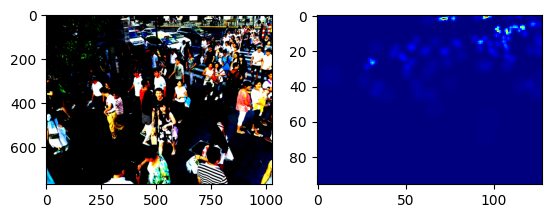

Ground-Truth Sum =  104.833336
Image shape is:  (768, 1024, 3)
Image type is:  float32
min/max size =  -2.117904 2.64


In [13]:
# View some of the training data
for (img_batch, label_batch) in train_ds.take(1):
    img, label = img_batch[0], tf.squeeze(label_batch[0]) # Index 0 because we are now batched
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img.numpy())
    axarr[1].imshow(label.numpy(),cmap=CM.jet)
    plt.show()
    print("Ground-Truth Sum = " ,np.sum(label.numpy() / 64))
    print('Image shape is: ', img.numpy().shape)
    print('Image type is: ', img.numpy().dtype)
    print('min/max size = ', np.min(img.numpy()), np.max(img.numpy()))

### Define Loss Functions

In [9]:
@tf.function
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    sub_var = tf.math.square(y_pred - y_true)
    #tf.print('Sub_var: ', sub_var)
    sum_square = tf.math.reduce_sum(sub_var)
    #tf.print('Sum_square: ', sum_square.shape, sum_square)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

### Define Model 

In [10]:
from keras.initializers import RandomNormal
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16

# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            channels = 3
            
            #Batch Normalisation option
            
            #batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            
            model = tf.keras.models.Sequential()
            model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, channels), kernel_initializer = init))
            model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            model.add(MaxPooling2D(strides=2))
            model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(MaxPooling2D(strides=2))
            model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(MaxPooling2D(strides=2))            
            model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                
                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same', name = 'output'))
        
            front_end = VGG16(weights='imagenet', include_top=False)
            
            weights_front_end = []
            for layer in front_end.layers:
                if 'conv' in layer.name:
                    weights_front_end.append(layer.get_weights())
            
            counter_conv = 0
            for i in range(len(model.layers)):
                if counter_conv >= 13:
                    break
                if 'conv' in model.layers[i].name:
                    model.layers[i].set_weights(weights_front_end[counter_conv])
                    counter_conv += 1
            
            #model = init_weights_vgg(model)
        
            return model

In [16]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = CrowdNet()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [17]:
from keras.optimizers.legacy import SGD

with strategy.scope():
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-6, decay_steps=10000, decay_rate=1e-4)
    sgd = SGD(learning_rate = 1e-6, decay = (1e-4), momentum = 0.95)
    #adam = Adam(lr = 1e-4, decay = (5*1e-3))
    model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
    #model.compile(optimizer=adam, loss=euclidean_distance_loss, metrics = ['mse'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 64)    0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 128)   0         
 g2D)                                                   

In [19]:
x = np.random.random((1,768,1024,3)).astype('float32')
#x = np.random.random((1,768,1024,1)).astype('float32')

In [20]:
model(x).shape

2023-12-15 22:00:56.320825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906


TensorShape([1, 96, 128, 1])

In [21]:
# Save the model according to the conditions 
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
save_path = Path('/code/training')
model_name = 'crowd_counting_model-dist'
checkpoint_path = save_path.joinpath("checkpoints",model_name,"epoch{epoch:02d}-loss{loss:.2f}-val_loss{val_loss:.2f}.keras")
# checkpoint = ModelCheckpoint(model_save_path+model_name+"_epoch{epoch:02d}-loss{loss:.2f}.h5", monitor='loss', verbose=1, save_best_only=True,  mode='max' )
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
log_path = save_path.joinpath("logs", model_name)
log_path.mkdir(parents=True, exist_ok=True)

callbacks = [
    ModelCheckpoint(str(checkpoint_path)),
    TensorBoard(str(log_path)),
    EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
]

In [22]:
# model.load_weights("/code/training/checkpoints/crowd_counting_model-dist/epoch05-loss197.44-val_loss203.51.keras")

In [23]:
EPOCHS = 10000
print("Training...")
H = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch = len(train_img_paths) // 4,
    validation_steps = 75,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Training...
Epoch 1/10000
INFO:tensorflow:Collective all_reduce tensors: 34 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 34 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/

2023-12-15 22:01:32.901901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906
2023-12-15 22:01:32.932099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906
2023-12-15 22:01:32.965615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906


100/100 [==============================] - ETA: 0s - loss: 319.0721 - mse: 16.5887INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
100/100 [==============================] - 29s 167ms/step - loss: 319.0721 - mse: 16.5887 - val_loss: 302.7042 - val_mse: 14.9362
Epoch 2/10000
100/100 [==============================] - 15s 146ms/step - loss: 317.7270 - mse: 16.5281 - val_loss: 305.5534 - val_mse: 15.3087
Epoch 3/10000
100/100 [==============================] - 15s 148ms/step - loss: 316.8130 - mse: 16.4806 - val_loss: 303.7874 - val_mse: 15.2430
Epoch 4/10000
100/100 [==============================] - 15s 146ms/step - loss: 316.2328 - mse: 16.4453 - val_loss: 302.9440 - val_mse: 14.9892
Epoch 5/10000
100/100 [==============================] - 15s 149ms/step - lo

In [25]:
#save_mod(model,"/data/crowd_counting/weights/model_A_weights.h5","/data/crowd_counting/models/Model_A.json")
model.save('/code/saved_models/crowd_counting.keras')

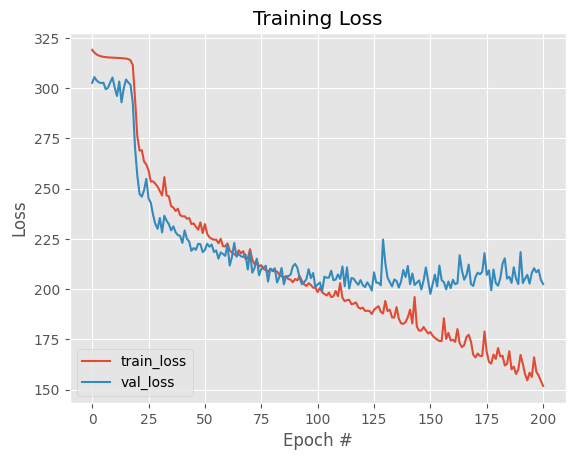

In [28]:
# plot the training loss and accuracy
N = 201
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), H.history["mse"], label="train_mse")
# plt.plot(np.arange(0, N), H.history["val_mean_squared_error"], label="val_mse")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [11]:
## Try some predictions to view output of model
# test_m = tf.keras.models.load_model("training/checkpoints/crowd_counting_model-dist/epoch60-loss217.69.h5", compile=False)
test_m = tf.keras.models.load_model("/code/saved_models/crowd_counting.keras", compile=False)

2023-12-16 19:30:03.043225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-12-16 19:30:03.043976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14783 MB memory:  -> device: 1, name: Tesla V100-DGXS-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2023-12-16 19:30:03.044677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14783 MB memory:  -> device: 2, name: Tesla V100-DGXS-16GB, pci bus id: 0000:0e:00.0, compute capability: 7.0
2023-12-16 19:30:03.045379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14783 MB memory:  -> device: 3, name: Tesla V100-DGXS-16GB, pci bus id

In [16]:
def predict(paths):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    imgs = [preprocess_img(read_image(path)) for path in paths]
    imgs = tf.stack(imgs)
    # img = tf.expand_dims(img, axis=0)
    
    heatmaps = test_m.predict(imgs)
    counts = tf.reduce_sum(tf.reshape(heatmaps, (heatmaps.shape[0],-1)), axis=1)

    return counts, imgs, heatmaps

1/1 [==============================] - 0s 104ms/step
Estimated People Count = 25
Ground truth People Count = 23


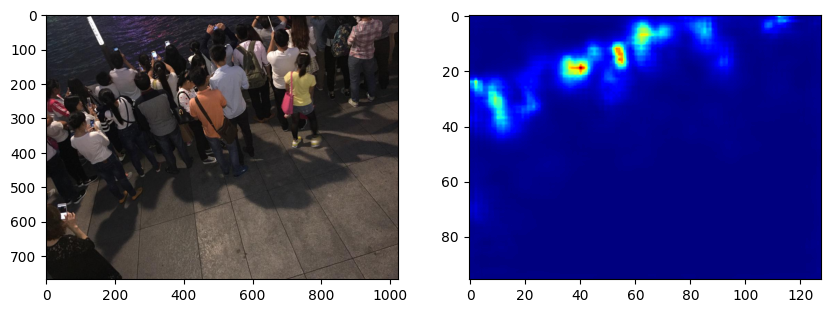

Estimated People Count = 45
Ground truth People Count = 48


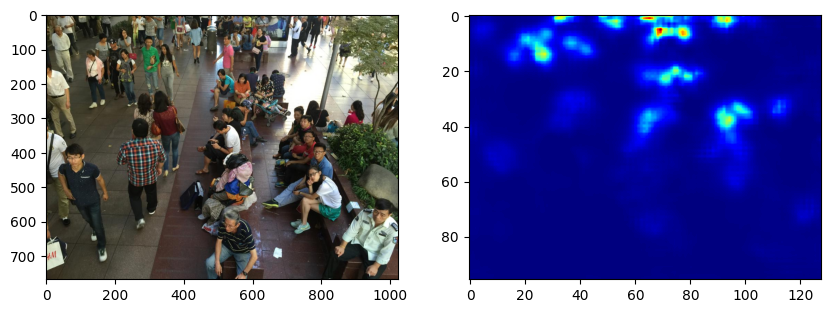

Estimated People Count = 62
Ground truth People Count = 57


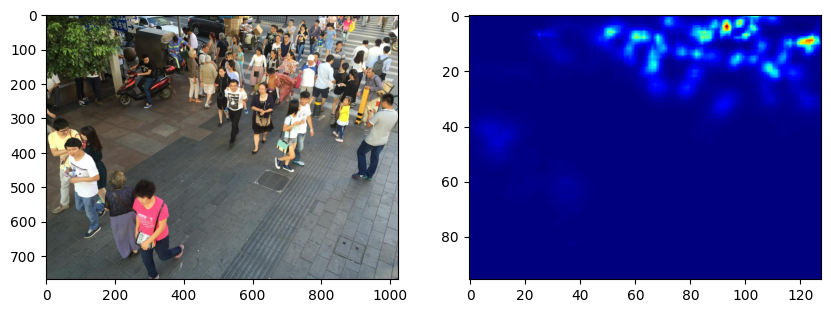

Estimated People Count = 267
Ground truth People Count = 278


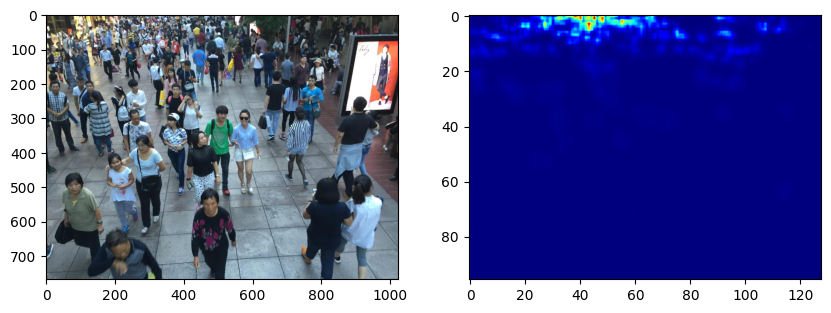

Estimated People Count = 138
Ground truth People Count = 138


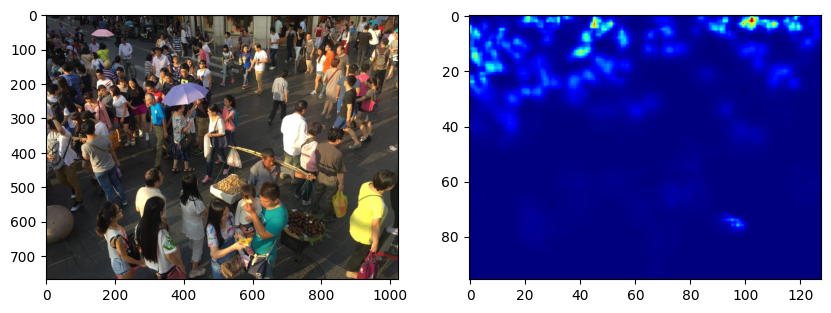

Estimated People Count = 11
Ground truth People Count = 8


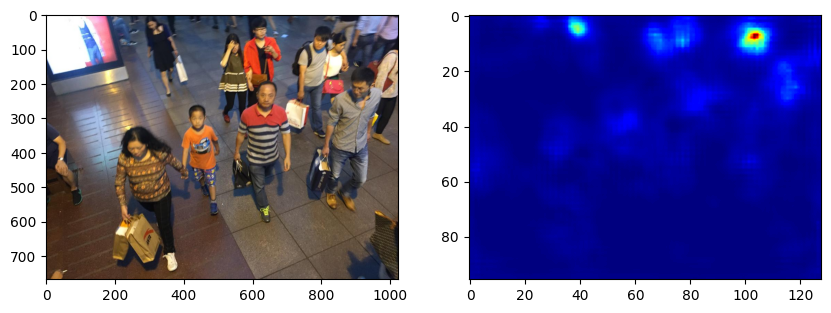

Estimated People Count = 185
Ground truth People Count = 191


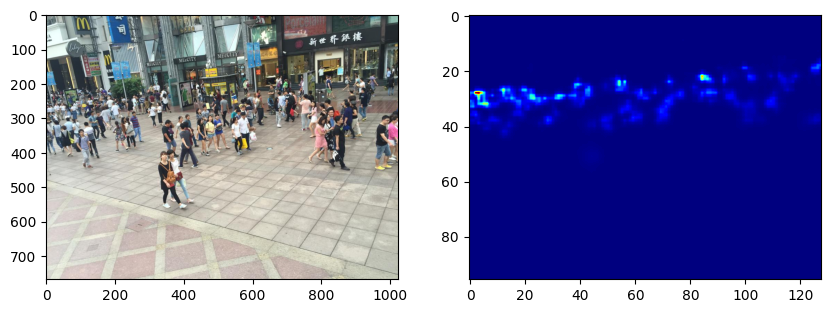

Estimated People Count = 23
Ground truth People Count = 21


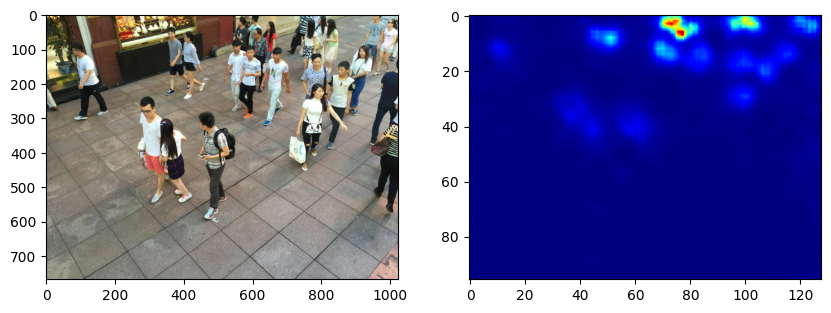

Estimated People Count = 93
Ground truth People Count = 85


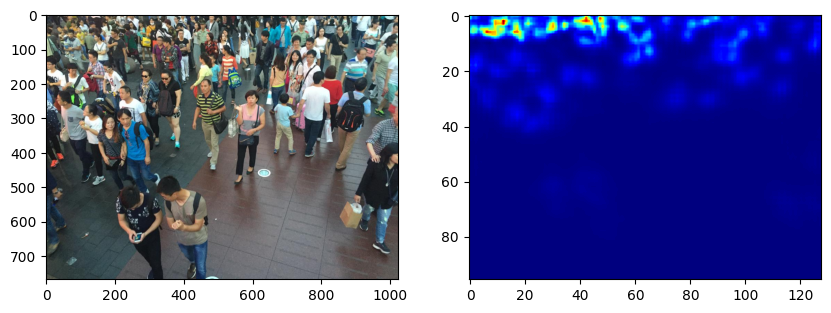

Estimated People Count = 150
Ground truth People Count = 142


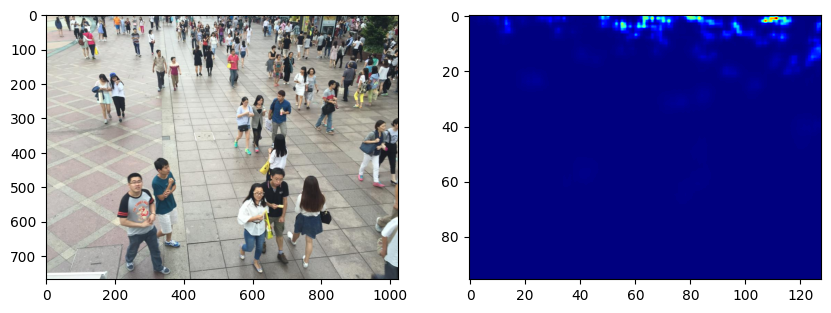

In [32]:
from PIL import Image
import random
## use a test image to check the prediction (e.g., inference)

test_images = random.sample(test_img_paths, 10)

## Get the Ground Truth heatmap
groundtruths = [preprocess_label(read_label(p), boost=False) for p in test_images]
# print("Ground Truth People Count = " ,int(np.sum(groundtruth)))

## Get the predicted values
# plt.rcParams["figure.figsize"] = (10,6)   # set plot sizes
counts, images, hmaps = predict(test_images)


for idx, count in enumerate(counts):
    f, axarr = plt.subplots(1,2)
    print(f"Estimated People Count = {round(int(count) / 64)}")
    print(f"Ground truth People Count = {round(np.sum(groundtruths[idx]))}")
    input_image = Image.open(test_images[idx])
    axarr[0].imshow(input_image)
    axarr[1].imshow(hmaps[idx], cmap = CM.jet)
    plt.show()
